# IMPORT REQUIRED LIBRARIES

In [28]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import scipy as sci
from datetime import datetime

#from sklearn.impute import SimpleImputer
#from scipy import interpolate
from sklearn.preprocessing import LabelEncoder

import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

from nltk import word_tokenize
from flatten_json import flatten

pd.set_option('max_columns', None)
pd.set_option('max_rows', 1000)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

sns.set_context('talk')
sns.set_style('whitegrid')
#sns.set_palette('rainbow')
#sns.set(context='talk' , style = 'whitegrid', palette = 'rainbow')
#sns.set_palette("RdPu", 10)

# LOAD JSON FILE 

In [114]:
with open("/Users/anjalirajwade/Documents/aditya/coding/spotify/MyData_adi/Playlist1.json")as f:
    data = json.load(f)  
# this is the file containing my playlists file

In [115]:
data1 = data['playlists']
for d in data1:
    d_row = d['items']
    n = d['name']
    da = d['lastModifiedDate']
    for row in d_row:
        row['name'] = n
        row['date'] = da

this is required to flatten the json file as it is in nested dictionary form

In [116]:
df_play = pd.json_normalize(data1,record_path='items')
df_play = df_play.drop(['episode','localTrack'],axis=1)
df_play.columns = df_play.columns.str.replace("[a-zA-Z]+\.",'')

<ipython-input-116-db3bfef18434>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



In [117]:
df = pd.read_json("/Users/anjalirajwade/Documents/aditya/coding/spotify/MyData_adi/StreamingHistory0.json")
# this is  the streaming history data


# add playlists to df 

In [118]:
def playlist(x): # def a user def function
    for i in range(len(df_play)):
        if x in df_play.trackName[i]:
            return df_play.name[i]

In [119]:
df['playlist'] = df.trackName.apply(lambda x : playlist(x))

In [120]:
df['playlist'] = df['playlist'].fillna('No Playlist')

# EXPLORE THE FILE

In [123]:
df.size

38495

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7699 entries, 0 to 7698
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     7699 non-null   object
 1   artistName  7699 non-null   object
 2   trackName   7699 non-null   object
 3   msPlayed    7699 non-null   int64 
 4   playlist    7699 non-null   object
dtypes: int64(1), object(4)
memory usage: 300.9+ KB


In [125]:
df.describe(include='all')

,endTime,artistName,trackName,msPlayed,playlist
count,7699,7699,7699,7.699000e+03,7699
unique,5020,592,1336,NaN,6
top,2020-08-23 15:34,Prabh Deep,The Warli Revolt,NaN,No Playlist
freq,31,401,65,NaN,2666
mean,NaN,NaN,NaN,1.086872e+05,NaN
std,NaN,NaN,NaN,1.471726e+05,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.935500e+03,NaN
50%,NaN,NaN,NaN,6.478600e+04,NaN
75%,NaN,NaN,NaN,1.892240e+05,NaN


# CONVERT MILISECONDS TO MINUTES

In [138]:
df['min_played'] = round(df['msPlayed']/60000,1)
df = df.drop('msPlayed',axis=1)

# new features

# work with date feature

In [126]:
df['endTime']= pd.to_datetime(df['endTime']) 
#df['createdDate_$date'] = df['createdDate_$date'].values.astype(dtype='datetime64[ms]')

In [132]:
def period(x):
    if x < 6 : 
        return 'Night'
    elif x < 12 :
        return 'Morning'
    elif x < 17 :
        return 'Afternoon'
    else :
        return 'Evening'
        

In [133]:
df['hour'] = df.endTime.dt.hour

In [134]:
df['period_of_day'] = df.hour.apply(lambda x : period(x))

# artist freq

In [135]:
df["artist_freq"] = (df.groupby("artistName")["artistName"].transform("count")/df.trackName.count()) 
# the frequency with which each track occurs in the dataset

the frequency with which each playlist occurs in each dataset

# find if a track was skipped without listening 

In [136]:
def skip1(x):
    if x < = 0.3 :
        return True
        
    else :
        return False

In [139]:
df['skip'] = df['min_played'].apply(lambda x : skip1(x))

# avg no. min spent listening to a particular track

let us exclude all the skipped tracks so as to not bring down the average

In [140]:
df['avg_minplayed'] = df[df.skip == False].groupby('trackName')['min_played'].transform('mean')

# find podcasts

In [141]:
podcasts = ['Maed in India', 'Cyrus Says','The Official Fantasy Premier League Podcast','My Dad Wrote A Porno']

In [142]:
def pod(x):
    if x in podcasts :
        return True
    else :
        return False
        

In [143]:
df['podcasts']  = df['artistName'].apply(lambda x : pod(x))

# giving random label id to playlist names

In [144]:
df['playlist_id'] = df.playlist.copy()
labels = df['playlist_id'].astype('category').cat.categories.tolist()
replace_map_comp = {'playlist_id' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
df.replace(replace_map_comp, inplace=True)  #replace the playlist_id with Integers
df['playlist_id'] = df['playlist_id'].fillna(0) 

# new df without podcasts

In [146]:
No_Pod = df[df['podcasts'] == False]
No_Pod = No_Pod.reset_index(drop=True)

# new df containing only playlists

In [147]:
Play = df[df.playlist != 'No Playlist'] 
Play = Play.reset_index(drop=True)

# new df containing no playlists

In [148]:
No_Play = df[df.playlist == 'No Playlist']
No_Play = No_Play.reset_index(drop=True)

# DATA VISUALIZTION & FIND PATTERNS

# let us consider playlists with no podcasts

In [287]:
pd.DataFrame(No_Pod.groupby([No_Pod.endTime.dt.day_name(),'playlist'])['min_played'].sum() 
             / No_Pod.groupby([No_Pod.endTime.dt.day_name()])['min_played'].sum()).T

endTime        Friday                                                         \
playlist   French pop Indie Hindi   Mixtape No Playlist   Rap out Relaxation   
min_played   0.010429    0.125079  0.160816    0.386049  0.157701   0.159926   

endTime        Monday                                                         \
playlist   French pop Indie Hindi   Mixtape No Playlist   Rap out Relaxation   
min_played   0.063951    0.009957  0.164645    0.547227  0.123764   0.090456   

endTime      Saturday                                                         \
playlist   French pop Indie Hindi   Mixtape No Playlist   Rap out Relaxation   
min_played   0.040231    0.121051  0.221242    0.423948  0.059363   0.134164   

endTime        Sunday                                                         \
playlist   French pop Indie Hindi   Mixtape No Playlist   Rap out Relaxation   
min_played   0.008367    0.181513  0.186586    0.358018  0.098498   0.167018   

endTime      Thursday                                                        \
playlist   French pop Indie Hindi   Mixtape No Playlist  Rap out Relaxation   
min_played    0.01144    0.095905  0.200952    0.420346  0.11499   0.156367   

endTime       Tuesday                                                         \
playlist   French pop Indie Hindi   Mixtape No Playlist   Rap out Relaxation   
min_played   0.039895    0.093726  0.146899    0.414558  0.134697   0.170225   

endTime     Wednesday                                                         
playlist   French pop Indie Hindi   Mixtape No Playlist   Rap out Relaxation  
min_played    0.02103    0.149755  0.168546    0.352693  0.170634   0.137342

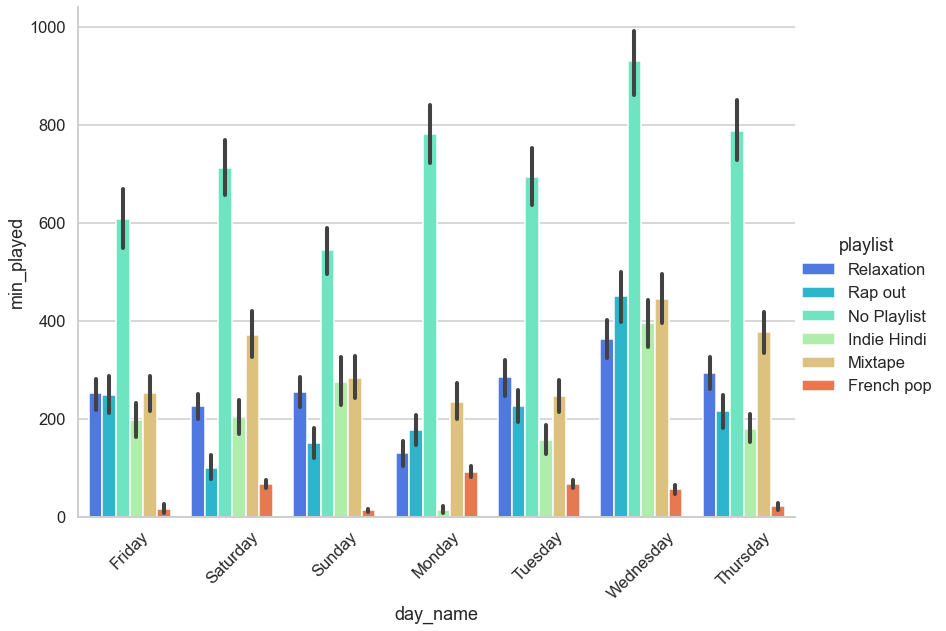

In [299]:
No_Pod['day_name']  = No_Pod.endTime.dt.day_name()
ax = sns.catplot(data = No_Pod , x = 'day_name' , hue = 'playlist' ,y = 'min_played' 
                 , kind = 'bar' ,height = 8 ,aspect = 1.4 , estimator=sum , ci = 90 )
ax.set_xticklabels(rotation=45)
plt.show()
No_Pod = No_Pod.drop('day_name',axis = 1)

# distribution of minutes played when song listened wasnt instantly skipped

this is a skewed data


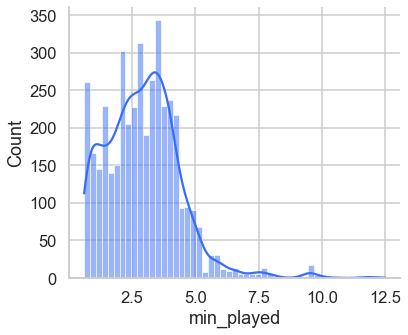

In [35]:
sns.displot(data = No_Pod[No_Pod.skip == False] , x = 'min_played', kind ='hist' , aspect=1.2 , kde = True ) 
print('this is a skewed data')

as we can data is skewed so let's calculate the coefficient of skewness and kurtosis

In [37]:
sci.stats.skew(No_Pod.min_played[No_Pod.skip==False])

1.0861264970289508

In [38]:
sci.stats.kurtosis(No_Pod.min_played[No_Pod.skip==False])

3.4758196967381165

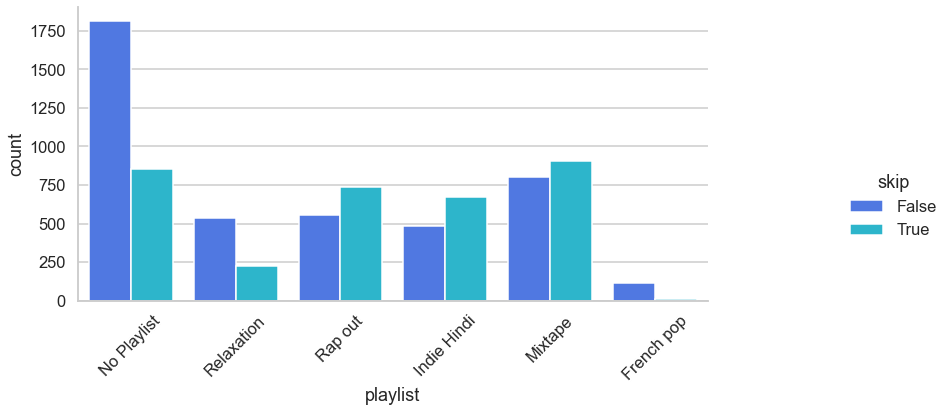

In [39]:
ax = sns.catplot(kind='count',data = df , x = 'playlist' , hue = 'skip' )

ax.set_xticklabels(rotation=45)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(5)
plt.show()

As can be seen from this data plot french pop music is the least likely to be skipped so as to understand it better,  let's show this in table form 


In [40]:
pd.DataFrame(df[df['skip']==False].groupby(['skip','playlist'])['skip'].count()/df.groupby('playlist')['playlist'].count())
# this is no. of times skipped or not / total no. times played

0
skip  playlist             
False French pop   0.895161
      Indie Hindi  0.419689
      Mixtape      0.471002
      No Playlist  0.680420
      Rap out      0.428904
      Relaxation   0.705416

In [41]:
#print(df.groupby(['playlist'])['min_played'].sum()*100/df.playlist.count() )
#print('this fraction represents the percentageof which a playlist')

# plot heatmap to find corelation

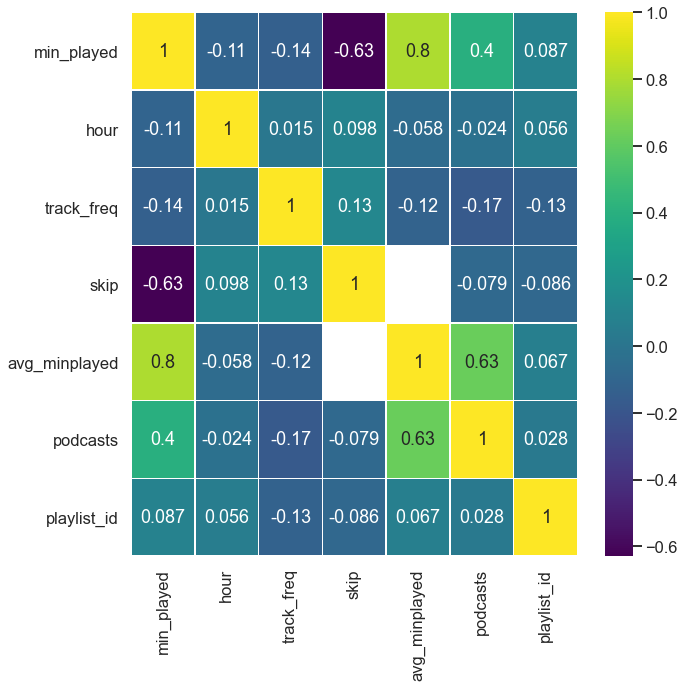

In [42]:
corremat = df.corr()      # plot heatmap . convert values 
plt.figure(figsize=(10,10))
g= sns.heatmap(corremat,annot=True,cmap='viridis',linewidths=.5)

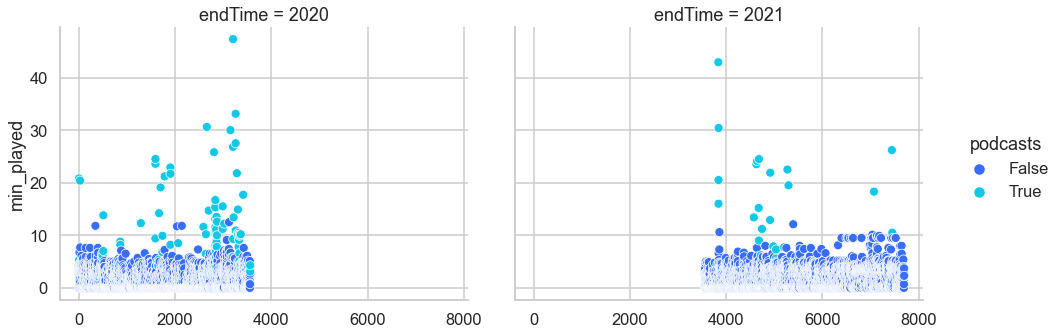

In [43]:
ax = sns.relplot(y = df.min_played , 
            x = df.index ,
            hue = df.podcasts ,
            col = df.endTime.dt.year ,
            kind ='scatter' )
ax.fig.set_figwidth(15)
ax.fig.set_figheight(5)

<Figure size 1440x720 with 0 Axes>

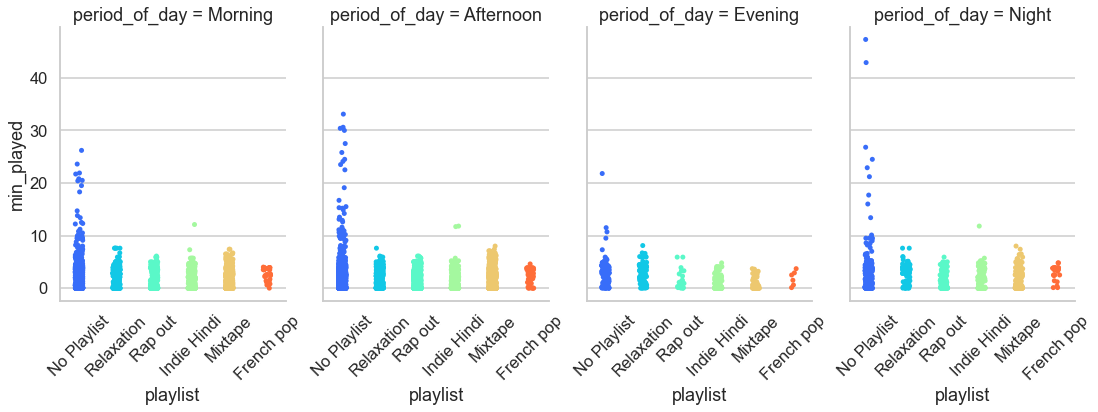

In [71]:
plt.figure(figsize=(20,10))
ax = sns.catplot(y = 'min_played', x = 'playlist', data = df , kind = 'strip' , 
            col = 'period_of_day' )
ax.set_xticklabels(rotation=45)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(5)
plt.show()

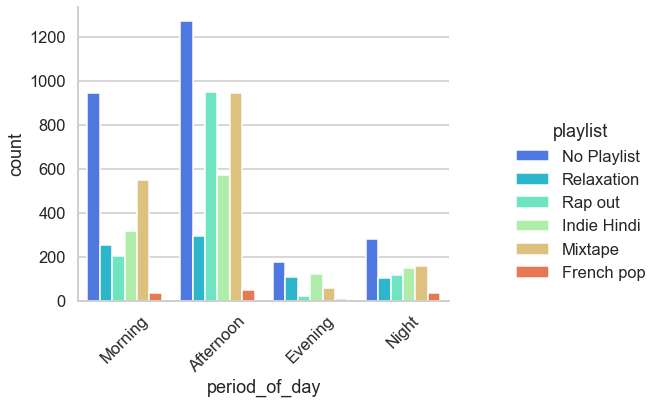

In [45]:
ax = sns.catplot(data = df , hue = 'playlist' , kind='count' , x = 'period_of_day'  )
plt.xticks(rotation=45)
ax.fig.set_figwidth(10)
ax.fig.set_figheight(5)
plt.show()

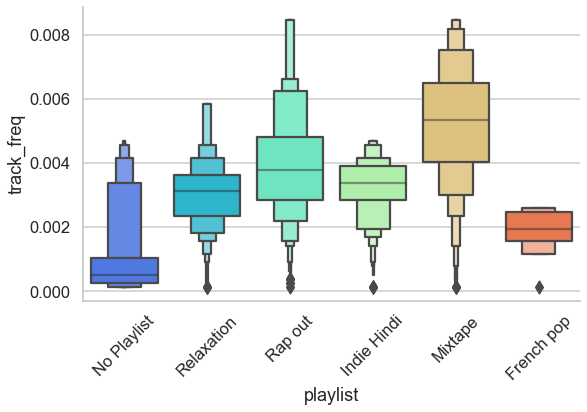

In [46]:
ax = sns.catplot(data = df , x = 'playlist' , y ='track_freq' , kind = 'boxen' )
ax.set_xticklabels(rotation=45)
ax.fig.set_figwidth(10)
ax.fig.set_figheight(5)

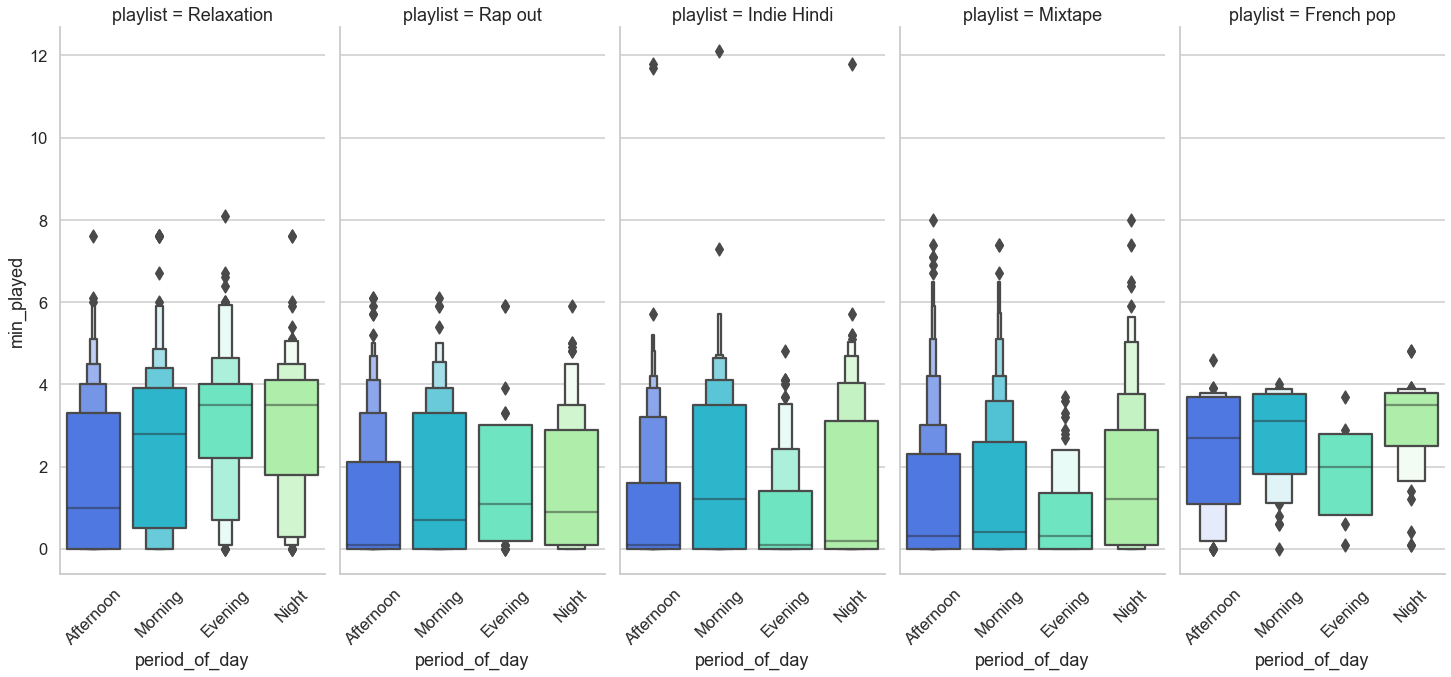

In [47]:
ax = sns.catplot(data = Play , x = 'period_of_day' , y ='min_played' , kind = 'boxen' , col = 'playlist' )
ax.set_xticklabels(rotation=45)
ax.fig.set_figwidth(20)
ax.fig.set_figheight(10)   # plot this in plotly

In [49]:
No_Pod.head(3)

,endTime,artistName,trackName,playlist,min_played,hour,period_of_day,track_freq,skip,avg_minplayed,podcasts,playlist_id
0,2020-06-05 12:36:00,Sulk Station,Wait (feat. Kamal),Relaxation,4.3,12,Afternoon,0.003247,False,3.338889,False,6
1,2020-06-06 09:37:00,SaltWater,Don't Even / Know Your Name,Relaxation,4.0,9,Morning,0.003767,False,3.292308,False,6
2,2020-06-06 09:41:00,SaltWater,Caves,Relaxation,3.9,9,Morning,0.003897,False,3.408000,False,6
